In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### A. Importing Libraries

In [2]:
import cv2 
import PIL
import random 
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import os 
from os import listdir 
import shutil

### B. Importing Data & Processing

In [3]:
train = torchvision.datasets.OxfordIIITPet("./data",split="trainval",target_types="segmentation",download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [4]:
imgs_path = "/kaggle/working/data/oxford-iiit-pet/images/"
masks_path = "/kaggle/working/data/oxford-iiit-pet/annotations/"
imgs_lst = os.listdir(imgs_path)
masks_lst = os.listdir(masks_path)
print(f"The number of files in images are {len(imgs_lst)} & files in annotations are {len(masks_lst)}")

The number of files in images are 7393 & files in annotations are 7


In [5]:
listdir(masks_path)

['trainval.txt',
 'trimaps',
 'xmls',
 'README',
 '._trimaps',
 'list.txt',
 'test.txt']

In [6]:
masks_list_path = masks_path + "list.txt"
masks_trimaps = masks_path + "._trimaps"
masks_trimaps_path = masks_path + "/trimaps/"
masks_train_path = masks_path + "trainval.txt"
masks_test_path = masks_path + "test.txt"
masks_xml_path = masks_path + "xmls/"

In [7]:
df1 = pd.read_csv(masks_train_path, sep=" ",names=["Image","Class_ID","Species_ID","Breed_ID"])
df2 = pd.read_csv(masks_test_path, sep=" ",names=["Image","Class_ID","Species_ID","Breed_ID"])
df = df1.append(df2) 
# df.sort_values("Class_ID",axis=0).head()
df.head()

,Image,Class_ID,Species_ID,Breed_ID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [8]:
image_names = [i.rsplit("_",1)[0] for i in df["Image"]]
class_ids = [i for i in df["Class_ID"]]
classes_info = {}
for i in range(len(image_names)):
    if image_names[i] not in classes_info:
        classes_info[image_names[i]] = class_ids[i]
for key,val in classes_info.items():
    print(key,val)

Abyssinian 1
american_bulldog 2
american_pit_bull_terrier 3
basset_hound 4
beagle 5
Bengal 6
Birman 7
Bombay 8
boxer 9
British_Shorthair 10
chihuahua 11
Egyptian_Mau 12
english_cocker_spaniel 13
english_setter 14
german_shorthaired 15
great_pyrenees 16
havanese 17
japanese_chin 18
keeshond 19
leonberger 20
Maine_Coon 21
miniature_pinscher 22
newfoundland 23
Persian 24
pomeranian 25
pug 26
Ragdoll 27
Russian_Blue 28
saint_bernard 29
samoyed 30
scottish_terrier 31
shiba_inu 32
Siamese 33
Sphynx 34
staffordshire_bull_terrier 35
wheaten_terrier 36
yorkshire_terrier 37


In [9]:
# Removing files in annotations trimaps starting with "._", to get only masked pngs
imgs_lst = [i for i in os.listdir(imgs_path) if not i.endswith(".mat")]
masks_lst = [os.path.splitext(file_name)[0]+".png" for file_name in imgs_lst]

In [10]:
corrupted_file_names = []
for file in imgs_lst:
    img_read = cv2.imread(imgs_path+file,1)
    if img_read is None:
        corrupted_file_names.append(file)
corrupted_mask_names = [i[:-4]+".png" for i in corrupted_file_names]
print("Before Removing: ",len(imgs_lst),len(masks_lst))
for file in corrupted_file_names:
    imgs_lst.remove(file)
for file in corrupted_mask_names:
    masks_lst.remove(file)
print("After removing: ",len(imgs_lst),len(masks_lst))

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Before Removing:  7390 7390
After removing:  7384 7384


In [11]:
imgs_lst,masks_lst = sorted(imgs_lst),sorted(masks_lst)
train_images_lst = imgs_lst[:6000]
val_images_lst = imgs_lst[6000:-10]
test_images_lst = imgs_lst[-10:]

* Trimaps visuals & understanding: https://stackoverflow.com/questions/41777654/opencv-using-a-trimap-image

In [12]:
def preprocessing_mask(mask):
  
    mask = mask.astype('float32')
    mask[mask==2.0] = 0.0 
    mask[(mask==1.0) | (mask==3.0)] = 1.0 
    return mask
    

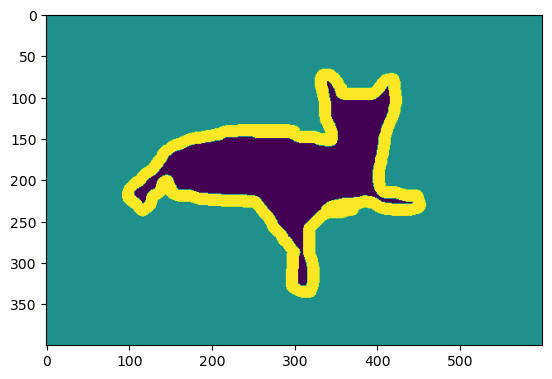

In [13]:
import io
import os
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import numpy as np

with tf.io.gfile.GFile(masks_trimaps_path+"/"+"Abyssinian_1.png", 'rb') as fid:
    encoded_mask_png = fid.read()
encoded_png_io = io.BytesIO(encoded_mask_png)
mask = PIL.Image.open(encoded_png_io)            
plt.imshow( np.array(mask) / 2 * 255 )

### C. Custom Dataset

In [14]:
class CustomDataset:
  def __init__(self,images_path,images_list,masks_path,masks_lst,transforms=None):
    self.images_path = images_path 
    self.images_list = images_list
    self.masks_path = masks_path 
    self.masks_lst = masks_lst 
    self.transforms = transforms 
  
  def __len__(self):
    return len(self.images_list) 
  
  def __getitem__(self,index):
    self.image_name = self.images_list[index] 
    self.image = cv2.imread(self.images_path+self.image_name)
    self.image = cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
   
    self.mask = cv2.imread(self.masks_path+self.image_name[:-4]+".png",-1)
    self.mask = preprocessing_mask(self.mask)
    
    if self.transforms: 
        transformed = self.transforms(image=self.image,mask=self.mask)
        self.image = transformed["image"]
        self.mask = transformed["mask"].unsqueeze(0)
        
   
    return self.image,self.mask
data = CustomDataset(imgs_path,imgs_lst,masks_trimaps_path,masks_lst)
# Choosing Images
# Removing masks starting with name "._" & choosing only files which dont start with "._"
# Reading Masks which has same name of image but with ".png" extension

In [16]:
train_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
    ToTensorV2()
])


In [17]:
train_data = CustomDataset(imgs_path,train_images_lst,masks_trimaps_path,masks_lst,transforms=train_transforms)
val_data = CustomDataset(imgs_path,val_images_lst,masks_trimaps_path,masks_lst,transforms=train_transforms)

In [18]:
next(iter(train_data))[1].shape

torch.Size([1, 256, 256])

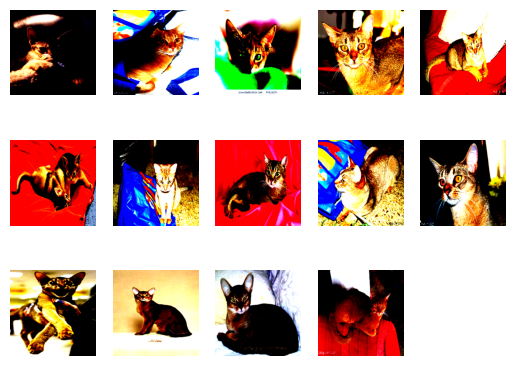

In [19]:
def plot_imgs(data,num_images,images=True):
  fig = plt.figure()
  rows = num_images//5 
  for i in range(1,num_images):
    plt.subplot(rows,5,i) 
    plt.axis('off')
    image = np.array(data[i][0].permute(1,2,0))
    mask = np.array(data[i][1])
    if images==True:
        plt.imshow(image)
    else:
        plt.imshow(mask.squeeze())
plot_imgs(train_data,num_images=15,images=True)

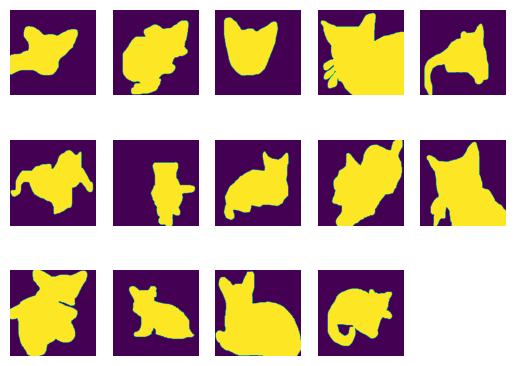

In [20]:
plot_imgs(train_data,num_images=15,images=False)

### D. Model Architecture

In [21]:
len(train_data),len(val_data)

(6000, 1374)

In [22]:
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=2, pin_memory=True) if "cuda" else dict(shuffle=True, batch_size=16)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
val_loader = torch.utils.data.DataLoader(val_data, **dataloader_args)
# (torch.tensor(test_data_x).to(device), torch.tensor(test_data_y).to(device)

In [23]:
image,labl = next(iter(train_loader))

In [24]:
labl.shape

torch.Size([32, 1, 256, 256])

In [25]:
print(image.shape,labl.shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


In [31]:
# ContractingBlock: Conv1 -> Conv2 -> O/P -> Maxpool(O/P) =) O/P + Maxpool(O/P)
class ContractingBlock(nn.Module):
  def __init__(self,in_channels,out_channels,strided_conv=True):
    super(ContractingBlock,self).__init__() 
    self.strided_conv = strided_conv

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True) 
    # in = 3, out = 64 , 128x128

    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True) 
    # 64,64,128x128
    if self.strided_conv:
        self.stridedConv = nn.Conv2d(out_channels,out_channels,kernel_size=2,stride=2)
        # (128-2)/2 + 1 = 63 + 1 = 64 
        # skip = 128x128
        # x = 64x64 

  def forward(self,x):
    x = self.conv1(x) 
    x = self.bn1(x) 
    x = self.relu1(x) 

    x = self.conv2(x) 
    x = self.bn2(x) 
    x = self.relu2(x) 

    skip = x 
    if self.strided_conv:
        x = self.stridedConv(x)
        return x,skip 
    else:
        x = x
        return x


class ExpandingBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(ExpandingBlock,self).__init__() 
    
    self.upsample = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2)
    # (input*S - 2P + (K-1) + 1 
    # (8*2 - 0 + (2-1) + 1) = 16 + 2 = 16
    
    
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True) 
    # 8x8 - Input 
    # (8+2-3) + 1 = 8

    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True) 
    # (8+2-3) + 1 = 8

   
  
  def forward(self,x,skip):
    x = self.upsample(x) 
    x = torch.cat((x,skip),dim=1)
    x = self.conv1(x)
    x = self.bn1(x) 
    x = self.relu1(x)
    x = self.conv2(x) 
    x = self.bn2(x) 
    x = self.relu2(x)
   
     # 16x16, skip = 32x32 
    return x 

class UNet(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(UNet,self).__init__() 

    self.contract1 = ContractingBlock(in_channels,64) 
    self.contract2 = ContractingBlock(64,128) 
    self.contract3 = ContractingBlock(128,256) 
    self.contract4 = ContractingBlock(256,512)
    self.contract5 = ContractingBlock(512,1024,False)
    
    self.expand0 = ExpandingBlock(1024,512)
    self.expand1 = ExpandingBlock(512,256) 
    self.expand2 = ExpandingBlock(256,128) 
    self.expand3 = ExpandingBlock(128,64) 

    self.final_conv = nn.Conv2d(64,1,kernel_size=1)
    
    self.sigma = nn.Sigmoid()

  def forward(self,x):
    x,skip1 = self.contract1(x) # 64x64x64, 128x128x64
    x,skip2 = self.contract2(x) # 32x32x128, 64x64x128
    x,skip3 = self.contract3(x) # 16x16x256, 32x32x256
    x,skip4 = self.contract4(x)     # 8x8x512, 16x16x512
    x = self.contract5(x)
    
    x = self.expand0(x,skip4)
    x = self.expand1(x,skip3) # 16x16x128 + 32x32x256 
    x = self.expand2(x,skip2) # 32x32x64 + 64x64x128
    x = self.expand3(x,skip1) # 64x64x32 + 128x128x64

    x = self.final_conv(x)
    
    return x
#     return self.sigma(x)



In [32]:
unet_arch = UNet(3,64).to("cuda")

In [33]:
!pip install torchsummary

In [34]:
from torchsummary import summary
summary(unet_arch,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
            Conv2d-7         [-1, 64, 128, 128]          16,448
  ContractingBlock-8  [[-1, 64, 128, 128], [-1, 64, 256, 256]]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

In [ ]:
# http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html
#https://debuggercafe.com/unet-from-scratch-using-pytorch/

In [35]:
train_loader,test_loader = train_loader,val_loader

In [36]:
len(train_loader),len(test_loader)

(188, 43)

In [37]:
from tqdm import tqdm
import torch.nn.functional as F

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(unet_arch, device, train_loader, optimizer,criterion, epoch):
    unet_arch.train()
    pbar = tqdm(train_loader)
    correct = 0 
    processed = 0 
    
    for batch_idx, (data,target) in enumerate(train_loader):
        data,target = data.to(device).float(),target.to(device).float()
        
        y_pred = unet_arch(data)
        loss = F.binary_cross_entropy_with_logits(y_pred,target)
        train_losses.append(loss)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 
        
        pred = y_pred.argmax(dim=1,keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += target.nelement()
    accuracy = 100*correct / processed
    print(f"epoch: {epoch} train loss: {loss.item():.3f} train accuracy: {accuracy:.2f}")
    
def test(unet_arch, device, test_loader,criterion):
    unet_arch.eval()
    test_loss = 0
    correct = 0
    qbar = tqdm(test_loader)
    total_tested = []
    with torch.no_grad():
        tested = 0
        for batch_idx,(data,target) in enumerate(test_loader):
            data,target = data.to(device).float(),target.to(device).float()
            output = unet_arch(data)
            test_loss += F.binary_cross_entropy_with_logits(output,target).item()
            corr_output = output.argmax(dim=1,keepdim=True)
            correct += corr_output.eq(target.view_as(corr_output)).sum().item()
            tested += target.nelement()
        test_accy = 100*correct/tested
        print(f"epoch: {epoch} test loss: {(test_loss/tested):.2f} train accuracy: {test_accy:.2f}")
        print("\n")
            
   
        

* Blog that helped to resolve very large train & val accuracy (bcoz of incorrect division of pixels with batch_size instead of pixel count): 
    
    https://discuss.pytorch.org/t/calculate-train-accuracy-of-the-model-in-segmentation-task/33581
    
* Loss func Blog: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [38]:
optimizer = optim.Adam(unet_arch.parameters(), lr=0.001)
EPOCHS = 1
device = "cuda"
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(unet_arch, device, train_loader, optimizer,criterion, epoch)
    test(unet_arch, device, test_loader,criterion)

EPOCH: 0


  0%|          | 0/188 [00:00<?, ?it/s]Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
  0%|          | 0/188 [03:20<?, ?it/s]


epoch: 0 train loss: 0.409 train accuracy: 57.31


  0%|          | 0/43 [00:14<?, ?it/s]

epoch: 0 test loss: 0.00 train accuracy: 61.94




* Reference: 
    
    1. https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb
    
    2. https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/
    
    3. https://colab.research.google.com/github/usuyama/pytorch-unet/blob/master/pytorch_unet_resnet18_colab.ipynb
        
        

In [39]:
dataloaders = {
  'train': train_loader,
  'val': test_loader
}

In [42]:
from collections import defaultdict
import torch.nn.functional as F

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0) 
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [41]:
def dice_loss(pred, target):
    smooth = 1e-5
    
    # flatten predictions and targets
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice 

In [43]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 1
model = unet_arch.to(device)



optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


train: bce: 0.361986, dice: 0.250935, loss: 0.306461
LR 0.0001
val: bce: 0.331952, dice: 0.233189, loss: 0.282570
saving best model to checkpoint.pth
3m 34s
Epoch 1/3
----------


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


train: bce: 0.344758, dice: 0.224240, loss: 0.284499
LR 0.0001
val: bce: 0.310284, dice: 0.220620, loss: 0.265452
saving best model to checkpoint.pth
3m 35s
Epoch 2/3
----------


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


train: bce: 0.326647, dice: 0.208681, loss: 0.267664
LR 0.0001
val: bce: 0.279623, dice: 0.200314, loss: 0.239968
saving best model to checkpoint.pth
3m 28s
Epoch 3/3
----------


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


train: bce: 0.314808, dice: 0.198193, loss: 0.256501
LR 0.0001
val: bce: 0.288205, dice: 0.192803, loss: 0.240504
3m 27s
Best val loss: 0.239968


In [ ]:
!zip model_ckpt.zip /kaggle/working/checkpoint.pth